In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [6]:
reload_recursive(helpers)

## Setup

In [7]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False

In [ ]:
# from mri_data.file_manager import scan_3Tpioneer_bids
# from mri_data import file_manager as fm
# from mri_data import utils
# from monai_training.preprocess import DataSetProcesser
# from loguru import logger

# logger.remove()

# df = pd.read_csv(data_dir / "t1_data_full.csv")
# mod = "t1"

# config = {
#     "t1": "t1_choroid_pineal_pituitary_T1-1_pred",
#     "flair": "flair_choroid_pineal_pituitary_FLAIR-1_pred",
# }


# inference_root = drive_root / "srs-9" / "3Tpioneer_bids_predictions"
# dataroot = drive_root / "3Tpioneer_bids"
# clinical_data_root = drive_root / "Secure_Data" / "Large"
# data_file_folder = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")
# inf_label = config[mod]

# def subject_to_subid(subject):
#     if not isinstance(subject, str):
#         return None
#     re_match = re.match(r"ms(\d{4})", subject)
#     if re_match:
#         return_val = int(re_match[1])
#         return return_val
#     else:
#         return None

# new_columns = {
#     "ID": "subject",
#     "age_at_obs_start": "age",
# }
# df.rename(columns=new_columns, inplace=True)
# df["subid"] = df["subject"].apply(subject_to_subid)
# df.drop(df[df["subid"].isna()].index, inplace=True)
# df["subid"] = df["subid"].astype(int)
# df = df.set_index("subid")

# new_columns = {}
# for col in df.columns:
#     new_columns[col] = col.replace(" ", "_")
# df.rename(columns=new_columns, inplace=True)


# dataset_proc = DataSetProcesser.new_dataset(
#     dataroot, scan_3Tpioneer_bids, filters=[fm.filter_first_ses]
# )
# full_dataset = dataset_proc.dataset
# dataset_proc.prepare_labels(
#     ["choroid_t1_flair", "pineal", "pituitary"], ["CH", "SRS", "ED", "DT"]
# )
# dataset = dataset_proc.dataset

# inference_dataset_proc = DataSetProcesser.new_dataset(
#     inference_root, scan_3Tpioneer_bids, filters=[fm.filter_first_ses]
# )
# inference_dataset_proc.prepare_labels(inf_label)
# inference_dataset = inference_dataset_proc.dataset


# segs = {}
# for scan in dataset:
#     segs[scan.subid] = scan.label_path
#     df.loc[int(scan.subid), ("sub-ses",)] = scan.relative_path
#     df.loc[int(scan.subid), ("label_folder",)] = scan.label_path.relative_to(drive_root).parent
#     df.loc[int(scan.subid), ("label",)] = scan.label

# for scan in inference_dataset:
#     segs[scan.subid] = scan.label_path
#     df.loc[int(scan.subid), ("sub-ses",)] = scan.relative_path
#     df.loc[int(scan.subid), ("label_folder",)] = scan.label_path.relative_to(drive_root).parent
#     df.loc[int(scan.subid), ("label",)] = scan.label


# df.to_csv(data_dir / "t1_data_full.csv")

In [10]:
df = pd.read_csv(data_dir / "flair_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [11]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [12]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [13]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [14]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [15]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

## Analysis

### Choroid Volumes

CP volume increased with age (β=0.38, p<0.001), TIV (β=0.16, p=0.001), and was smaller in females (β=-0.15, p=0.002), but was not associated with the presence of MS (β=0.18, p=0.10)

In [16]:
model_data = df_z[df_z['dz_type2'].isin(["MS", "!MS"])]
res = sm.OLS.from_formula(
    "choroid_volume ~ dz_type2 + age + tiv + Female", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.170
R2_adj: 0.163
                    coef             p
Intercept      -0.099049  3.637084e-01
dz_type2[T.MS]  0.123316  2.994364e-01
age             0.283363  1.936168e-10
tiv             0.223337  2.066901e-05
Female         -0.103777  4.727573e-02


Within the population of MS patients, those with PMS had greater CP volumes than those with RMS, after controlling for age, sex, and TIV (β=0.36, p=0.003). 

In [20]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]
res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.282
R2_adj: 0.263
                     coef         p
Intercept        0.119560  0.484104
dz_type5[T.RMS] -0.424951  0.033932
Female          -0.215741  0.017514
age              0.301072  0.000150
tiv              0.124203  0.196979


In a multivariable regression controlling for age, sex, and TIV, CP volume increased with WM lesion volume (β=0.21, p<0.001) and number of PRL lesions (β=0.16, p<0.001). There was still a significant positive association with PMS (β=0.27. p=0.019)

In [21]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]
res = sm.OLS.from_formula("choroid_volume ~ lesion_vol_cubic + PRL + dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.308
R2_adj: 0.281
                      coef         p
Intercept         0.051344  0.764302
dz_type5[T.RMS]  -0.337788  0.094676
lesion_vol_cubic  0.200883  0.053890
PRL               0.055948  0.464164
Female           -0.226250  0.012346
age               0.257653  0.004075
tiv               0.088352  0.358394


An ANCOVA was conducted to examine differences in CP volume amongst the RMS, PMS, OIND, and NIND groups, controlling for age, sex, and TIV. The analysis revealed a significant main effect for disease phenotype on CP volume (p < 0.001). Post hoc Tukey's HSD comparisons indicated that PMS had significantly larger CP than both NIND (p=0.043, d=0.51) and RMS (p=0.011, d=0.42). Additionally, sex (p<0.001), age (p<0.001), and TIV (p=0.006) were significant covariates. 

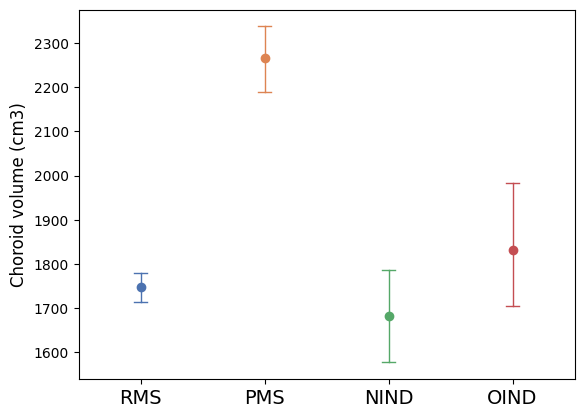

In [22]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]
model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]

res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()
# Extract marginal means (using 'Group')
marginal_means = res.predict(model_data[['Female', 'age', 'tiv', 'dz_type5']].drop_duplicates())

f = plt.figure()
ax = sns.pointplot(x='dz_type5', y=marginal_means, data=model_data, 
              palette='deep', hue='dz_type5', legend=False, markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=5, markeredgewidth=2, linewidth=1)
ax.set_ylabel("Choroid volume (cm3)", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(["RMS", "PMS", "NIND", "OIND"])
ax.set_xticklabels(["RMS", "PMS", "NIND", "OIND"], fontsize=14)
f.patch.set_alpha(0)

The best performing regression model for predicting CP volume in MS patients had an R² of 0.37 (adj R²=0.35).

In [15]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + lesion_count + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     23.84
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           5.10e-32
Time:                        15:05:10   Log-Likelihood:                -2899.9
No. Observations:                 376   AIC:                             5820.
Df Residuals:                     366   BIC:                             5859.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          682.2914    473.217  

### Clinical Disability

In [25]:
model_data = df.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]
model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]

predictors = ["choroid_volume", "tiv", "age", "Female"]
outcome = ["EDSS"]
model_data[predictors] = model_data[predictors].apply(stats.zscore, nan_policy='omit')

model_data2 = data.copy()
model_data2['age'] = model_data2['choroid_volume'] - (model_data2['choroid_volume']).mean()

model = sm.OLS.from_formula("edss_sqrt ~ lesion_vol_cubic + choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
print(res.summary())
# print("p values:")
# print("Choroid volume: {:0.2}".format(res_prob.pvalues['choroid_volume']))
# print("Lesion volume:  {:0.2}".format(res_prob.pvalues['lesion_vol_cubic']))

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     12.79
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           2.67e-10
Time:                        12:01:07   Log-Likelihood:                -108.63
No. Observations:                 151   AIC:                             229.3
Df Residuals:                     145   BIC:                             247.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2921      0.121  

In [26]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()
model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]

mod_prob = OrderedModel.from_formula("EDSS ~ choroid_volume + tiv + age + Female",
                                     data=model_data, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.228074
         Iterations: 74
         Function evaluations: 77
         Gradient evaluations: 77


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -327.53
Model:                   OrderedModel   AIC:                             695.1
Method:            Maximum Likelihood   BIC:                             754.9
Date:                Fri, 28 Feb 2025                                         
Time:                        12:01:17                                         
No. Observations:                 147                                         
Df Residuals:                     127                                         
Df Model:                           4                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
choroid_volume     1.3396      0.550      2.435      0.015       0.262       2.418
tiv               -1.1028      2.253     -0.489      0.625      -5.519       3.313
age                3.0858      0.610      5.059      0.000       1.890       4.281
Female             0.0721      0.440      0.164      0.870      -0.790       0.934
0.0/1.0           -0.9829      2.629     -0.374      0.708      -6.135       4.169
1.0/1.5            0.9577      0.220      4.353      0.000       0.527       1.389
1.5/2.0            0.2246      0.168      1.338      0.181      -0.104       0.554
2.0/2.5           -0.1976      0.195     -1.012      0.311      -0.580       0.185
2.5/3.0           -1.4115      0.369     -3.821      0.000      -2.136      -0.688
3.0/3.5           -1.2595      0.344     -3.656      0.000      -1.935      -0.584
3.5/4.0           -1.2014      0.344     -3.493      0.000      -1.876      -0.527
4.0/4.5           -1.2645      0.368     -3.432      0.001      -1.986      -0.542
4.5/5.0           -2.4553      0.701     -3.500      0.000      -3.830      -1.080
5.0/5.5           -1.9971      0.570     -3.501      0.000      -3.115      -0.879
5.5/6.0           -2.3366      0.701     -3.333      0.001      -3.711      -0.963
6.0/6.5           -0.1319      0.255     -0.517      0.605      -0.632       0.368
6.5/7.0           -0.1244      0.347     -0.359      0.720      -0.804       0.555
7.0/7.5           -1.0053      0.702     -1.433      0.152      -2.380       0.370
7.5/8.0           -0.6156      0.706     -0.872      0.383      -1.999       0.768
8.0/8.5            0.1213      0.734      0.165      0.869      -1.318       1.560
==================================================================================
"""

#### MSSS

In [20]:
model = sm.OLS.from_formula("msss_sqrt ~ tiv + Female + lesion_vol_cubic + choroid_volume", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              msss_sqrt   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.268
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0613
Time:                        16:36:36   Log-Likelihood:                -417.23
No. Observations:                 403   AIC:                             844.5
Df Residuals:                     398   BIC:                             864.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5095      0.522  

#### ARMSS

In [21]:
model = sm.OLS.from_formula("armss_sqrt ~ choroid_volume + tiv + Female + age", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.939
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.49e-06
Time:                        16:36:50   Log-Likelihood:                -412.59
No. Observations:                 440   AIC:                             835.2
Df Residuals:                     435   BIC:                             855.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0896      0.480      6.

### Mediation

In [20]:
p2 = Process(data=data_ms_z, model=3, x="choroid_volume", y="edss_sqrt", w="dzdur",
            m=["lesion_vol_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 3

Variables:
    Cons = Cons
    x = choroid_volume
    y = edss_sqrt
    w = dzdur
    m = lesion_vol_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
412

***************************** OUTCOME MODELS ****************************

Outcome = edss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2929   0.2727 0.7273 15.9886   10  386   0.0000

Coefficients

                                           coeff     se       t      p    LLCI   ULCI
Cons                                     -0.0685 0.0478 -1.4335 0.1525 -0.1621 0.0251
choroid_volume                            0.0038 0.0560  0.0683 0.9456 -0.1060 0.1136
lesion_vol_logtrans                       0.1401 0.0501  2.7947 0.0055  0.0418 0.2384
dzdur                                     0.1875 0.0591

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


In [28]:
model_data = df_z.copy()
model_data = model_data.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = model_data[model_data['flair_contrast'] == "WITHOUT"]

outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=model_data
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=model_data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.048366,-0.008678,0.132099,0.104
ACME (treated),0.048366,-0.008678,0.132099,0.104
ADE (control),0.116328,-0.038896,0.269139,0.132
ADE (treated),0.116328,-0.038896,0.269139,0.132
Total effect,0.164694,-0.003506,0.311090,0.054
Prop. mediated (control),0.268350,-0.183933,1.343839,0.122
Prop. mediated (treated),0.268350,-0.183933,1.343839,0.122
ACME (average),0.048366,-0.008678,0.132099,0.104
ADE (average),0.116328,-0.038896,0.269139,0.132
Prop. mediated (average),0.268350,-0.183933,1.343839,0.122


### Predicting MS Phenotype

Logistic regression on PMS

In [28]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("PMS ~ pituitary_volume + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.381034
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  412
Model:                          Logit   Df Residuals:                      407
Method:                           MLE   Df Model:                            4
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                  0.2514
Time:                        21:45:29   Log-Likelihood:                -156.99
converged:                       True   LL-Null:                       -209.72
Covariance Type:            nonrobust   LLR p-value:                 6.737e-22
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.1839      0.790     -1.498      0.134      -2.732       0.365
pituitary_v